In [1]:
import numpy as np
import pandas as pd
from util import (BOHR, read_mat, read_comp, get_iso, get_aniso, read_by_prompt, get_df_err, get_rmsre_3comp, get_relrmsd_3comp)
import itertools
import warnings
import basis_set_exchange as bse
from functools import partial

warnings.filterwarnings("ignore")
np.set_printoptions(8, suppress=True, linewidth=150)
pd.set_option('display.max_rows', None)
pd.set_option("display.precision", 3)
pd.set_option("float_format", '{:.3f}'.format)

In [180]:
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
from matplotlib.mlab import GaussianKDE
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
%matplotlib inline

set_matplotlib_formats('svg')

In [6]:
df_res = pd.read_csv("benchmark.csv", index_col=[0], header=[0, 1])

In [143]:
mask_wft = df_res["information", "type"] == "WFT"
mask_lda = df_res["information", "type"] == "LDA"
mask_gga = df_res["information", "type"] == "GGA"
mask_mgga = df_res["information", "type"] == "mGGA"
mask_hyb_ex = ~pd.isna(df_res["information", "hybrid ex"]) & ~mask_wft
mask_hyb_corr = ~pd.isna(df_res["information", "hybrid corr"]) & ~mask_wft
mask_dh = mask_hyb_corr
mask_low = ~mask_hyb_corr & ~mask_wft
mask_xdh = mask_dh & ~pd.isna(df_res["information", "XYG3-type"])
mask_bdh = mask_dh & pd.isna(df_res["information", "XYG3-type"])
mask_rsh = (df_res["information", "hybrid ex"] == "range-separate")

## 常用函数

In [123]:
# Gaussian KDE estimation

def get_gaussian_kde(dat, bw_method=None, width=0.5, points=1000):
    kde = GaussianKDE(dat, bw_method=bw_method)
    x = np.linspace(np.min(dat), np.max(dat), points)
    y = kde.evaluate(x)
    y *= width / y.max()
    return np.array([x, y])

In [159]:
# violin-box plot for two axes

def plot_bi_violinbox(ax, dat1, dat2, bw_method=0.2, width=0.25, x=1, c1="C0", c2="C1"):
    kde_xy = get_gaussian_kde(dat1, bw_method=bw_method, width=width)
    ax.fill_betweenx(kde_xy[0], x - kde_xy[1], x, alpha=width, color=c1, edgecolor=None)
    kde_xy = get_gaussian_kde(dat2, bw_method=bw_method, width=width)
    ax.fill_betweenx(kde_xy[0], x + kde_xy[1], x, alpha=width, color=c2, edgecolor=None)
    
    b1 = ax.boxplot(dat1, vert=True, whis=10, positions=[x - width - 0.1])
    b2 = ax.boxplot(dat2, vert=True, whis=10, positions=[x + width + 0.1])
    
    for bplot, color in zip((b1, b2), (c1, c2)):
        for widget in bplot["boxes"] + bplot["caps"] + bplot["whiskers"] + bplot["medians"]:
            widget.set_color(color)
    return ax

## compares

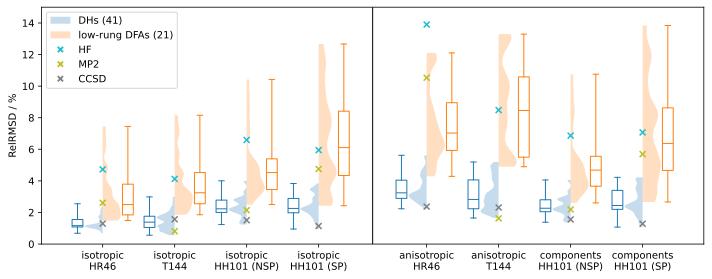

In [215]:
fig, ax = plt.subplots(figsize=(10, 4))

d_list = [
    ("isotropic", "HR46"), ("isotropic", "T144"), ("isotropic", "HH101 (NSP)"), ("isotropic", "HH101 (SP)"),
    ("anisotropic", "HR46"), ("anisotropic", "T144"), ("components", "HH101 (NSP)"), ("components", "HH101 (SP)")]
x_list = [0, 1, 2, 3, 4.5, 5.5, 6.5, 7.5]

for d, x in zip(d_list, x_list):
    plot_bi_violinbox(ax, df_res[mask_dh][d], df_res[mask_low][d], x=x, c1="C0", c2="C1")
    ax.scatter(x, df_res.loc["CCSD", d], color="C7", marker="x")
    ax.scatter(x, df_res.loc["MP2", d], color="C8", marker="x")
    ax.scatter(x, df_res.loc["HF", d], color="C9", marker="x")
ax.plot([3.75] * 2, [0, 100], color="black", linewidth=1)

ax.set_xticks(x_list)
ax.set_xticklabels(["\n".join(d) for d in d_list])
ax.set_ylabel("RelRMSD / %")

ax.set_ylim(0, 15)
ax.legend(handles=[
    Patch(facecolor="C0", alpha=0.25, label="DHs (41)"),
    Patch(facecolor="C1", alpha=0.25, label="low-rung DFAs (21)"),
    Line2D([0], [0], marker="X", color="w", markersize=8, markerfacecolor="C9", label="HF"),
    Line2D([0], [0], marker="X", color="w", markersize=8, markerfacecolor="C8", label="MP2"),
    Line2D([0], [0], marker="X", color="w", markersize=8, markerfacecolor="C7", label="CCSD"),
])

fig.tight_layout()
fig.savefig("../benchmark-compare-dh-low.pdf", transparent=True)

In [231]:
(df_res["components", "HH101 (NSP)"] < df_res["isotropic", "HH101 (NSP)"]).sum()

0

In [232]:
(df_res["components", "HH101 (SP)"] < df_res["isotropic", "HH101 (SP)"]).sum()

0

In [227]:
(
    (df_res["anisotropic", "HR46"] - df_res["isotropic", "HR46"]).mean(),
    (df_res["anisotropic", "HR46"][mask_dh] - df_res["isotropic", "HR46"][mask_dh]).mean(),
    (df_res["anisotropic", "HR46"][mask_low] - df_res["isotropic", "HR46"][mask_low]).mean(),
)

(3.0629652536486045, 2.142233041325276, 4.432715019576462)

In [229]:
(
    (df_res["anisotropic", "T144"] - df_res["isotropic", "T144"]).mean(),
    (df_res["anisotropic", "T144"][mask_dh] - df_res["isotropic", "T144"][mask_dh]).mean(),
    (df_res["anisotropic", "T144"][mask_low] - df_res["isotropic", "T144"][mask_low]).mean(),
)

(2.7039965729845465, 1.6850622259934265, 4.797987054558885)

In [233]:
(
    (df_res["components", "HH101 (NSP)"] - df_res["isotropic", "HH101 (NSP)"]).mean(),
    (df_res["components", "HH101 (NSP)"][mask_dh] - df_res["isotropic", "HH101 (NSP)"][mask_dh]).mean(),
    (df_res["components", "HH101 (NSP)"][mask_low] - df_res["isotropic", "HH101 (NSP)"][mask_low]).mean(),
)

(0.09832898796103724, 0.05946537588687157, 0.1707468399424729)

In [234]:
(
    (df_res["components", "HH101 (SP)"] - df_res["isotropic", "HH101 (SP)"]).mean(),
    (df_res["components", "HH101 (SP)"][mask_dh] - df_res["isotropic", "HH101 (SP)"][mask_dh]).mean(),
    (df_res["components", "HH101 (SP)"][mask_low] - df_res["isotropic", "HH101 (SP)"][mask_low]).mean(),
)

(0.3584652906701406, 0.2829747158341431, 0.45211671865574604)

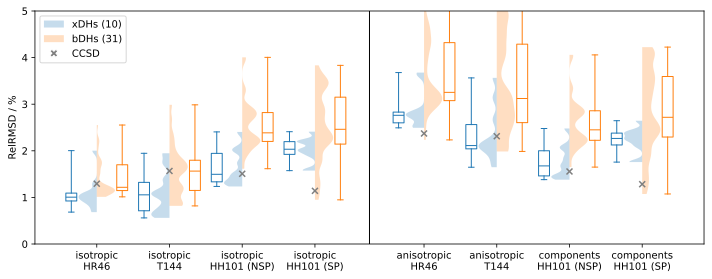

In [235]:
fig, ax = plt.subplots(figsize=(10, 4))

d_list = [
    ("isotropic", "HR46"), ("isotropic", "T144"), ("isotropic", "HH101 (NSP)"), ("isotropic", "HH101 (SP)"),
    ("anisotropic", "HR46"), ("anisotropic", "T144"), ("components", "HH101 (NSP)"), ("components", "HH101 (SP)")]
x_list = [0, 1, 2, 3, 4.5, 5.5, 6.5, 7.5]

for d, x in zip(d_list, x_list):
    plot_bi_violinbox(ax, df_res[mask_xdh][d], df_res[mask_bdh][d], x=x, c1="C0", c2="C1")
    ax.scatter(x, df_res.loc["CCSD", d], color="C7", marker="x")
ax.plot([3.75] * 2, [0, 100], color="black", linewidth=1)

ax.set_xticks(x_list)
ax.set_xticklabels(["\n".join(d) for d in d_list])
ax.set_ylabel("RelRMSD / %")

ax.set_ylim(0, 5)
ax.legend(handles=[
    Patch(facecolor="C0", alpha=0.25, label="xDHs (10)"),
    Patch(facecolor="C1", alpha=0.25, label="bDHs (31)"),
    Line2D([0], [0], marker="X", color="w", markersize=8, markerfacecolor="C7", label="CCSD"),
])

fig.tight_layout()
fig.savefig("../benchmark-compare-xdh-bdh.pdf", transparent=True)

In [248]:
df_res["isotropic", "HH101 (SP)"][mask_xdh].sort_values()

XYG7         1.575
XYGJ-OS      1.592
XYG6         1.905
XYG5         1.981
lrc-XYG3     2.020
XYG3         2.047
revXYGJ-OS   2.187
XYG-OS5      2.200
xDH-PBE0     2.216
revXYG3      2.410
Name: (isotropic, HH101 (SP)), dtype: float64

In [249]:
df_res["isotropic", "HH101 (SP)"][mask_bdh].sort_values()

ωPBEPP86           0.949
ωB88PP86           1.130
DSD-PBEP86-D3BJ    1.317
DSD-PBEPBE-D3BJ    1.412
PBE-QIDH           1.775
DSD-BLYP-D3BJ      1.776
ωB2GP-PLYP         1.829
PBE-CIDH           2.100
SOS0-PBE-QIDH      2.188
ωB97X-2-TQZ        2.196
RSX-QIDH           2.226
B2GP-PLYP          2.254
PBE0-DH            2.286
SOS0-PBE0-DH       2.320
ωB2PLYP            2.362
TPSS-QIDH          2.462
PTPSS-D3Zero       2.477
SOS-RSX-PBE-QIDH   2.662
RSX-0DH            2.683
SOS-RSX-PBE0-DH    2.850
TPSS-CIDH          2.889
revPBE0-DH         2.936
TPSS0-DH           3.028
mPW2PLYP           3.273
PBE0-2             3.393
RS-PBE-PBE         3.445
B2PLYP             3.468
RS-PW91-PW91       3.474
RS-PBE-P86         3.491
RS-B88-LYP         3.622
LS1DH-PBE          3.833
Name: (isotropic, HH101 (SP)), dtype: float64

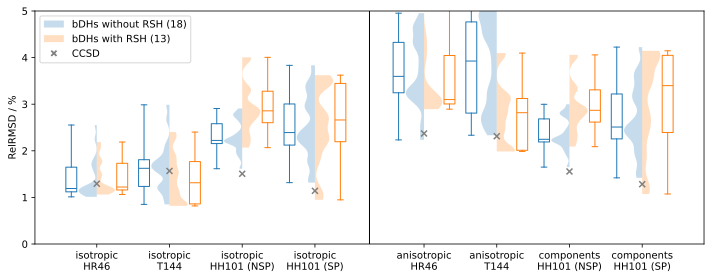

In [255]:
fig, ax = plt.subplots(figsize=(10, 4))

d_list = [
    ("isotropic", "HR46"), ("isotropic", "T144"), ("isotropic", "HH101 (NSP)"), ("isotropic", "HH101 (SP)"),
    ("anisotropic", "HR46"), ("anisotropic", "T144"), ("components", "HH101 (NSP)"), ("components", "HH101 (SP)")]
x_list = [0, 1, 2, 3, 4.5, 5.5, 6.5, 7.5]

for d, x in zip(d_list, x_list):
    plot_bi_violinbox(ax, df_res[mask_bdh & ~mask_rsh][d], df_res[mask_bdh & mask_rsh][d], x=x, c1="C0", c2="C1")
    ax.scatter(x, df_res.loc["CCSD", d], color="C7", marker="x")
ax.plot([3.75] * 2, [0, 100], color="black", linewidth=1)

ax.set_xticks(x_list)
ax.set_xticklabels(["\n".join(d) for d in d_list])
ax.set_ylabel("RelRMSD / %")

ax.set_ylim(0, 5)
ax.legend(handles=[
    Patch(facecolor="C0", alpha=0.25, label="bDHs without RSH (18)"),
    Patch(facecolor="C1", alpha=0.25, label="bDHs with RSH (13)"),
    Line2D([0], [0], marker="X", color="w", markersize=8, markerfacecolor="C7", label="CCSD"),
])

fig.tight_layout()
fig.savefig("../benchmark-compare-dh-rsh.pdf", transparent=True)

## scratch

In [266]:
# df_res[mask_bdh & mask_rsh].sort_values(("wtmad", "wtmad"))
df_res[mask_bdh & mask_rsh].sort_values(("isotropic", "HH101 (NSP)"))

information                                                 \
                        year type       hybrid ex     hybrid corr XYG3-type   
ωPBEPP86                2021  GGA  range-separate          hybrid       NaN   
ωB88PP86                2021  GGA  range-separate          hybrid       NaN   
ωB2GP-PLYP              2019  GGA  range-separate          hybrid       NaN   
RS-B88-LYP              2021  GGA  range-separate  range-separate       NaN   
ωB2PLYP                 2019  GGA  range-separate          hybrid       NaN   
ωB97X-2-TQZ             2009  GGA  range-separate          hybrid       NaN   
RS-PBE-PBE              2021  GGA  range-separate  range-separate       NaN   
RS-PBE-P86              2021  GGA  range-separate  range-separate       NaN   
RS-PW91-PW91            2021  GGA  range-separate  range-separate       NaN   
RSX-QIDH                2018  GGA  range-separate          hybrid       NaN   
SOS-RSX-PBE-QIDH        2021  GGA  range-separate          hybrid       NaN   
RSX-0DH                 2019  GGA  range-separate          hybrid       NaN   
SOS-RSX-PBE0-DH         2021  GGA  range-separate          hybrid       NaN   

                 isotropic                              anisotropic        \
                      HR46  T144 HH101 (NSP) HH101 (SP)        HR46  T144   
ωPBEPP86             1.093 1.069       2.068      0.949       3.252 2.542   
ωB88PP86             1.434 1.490       2.225      1.130       2.978 2.817   
ωB2GP-PLYP           1.062 1.140       2.374      1.829       3.005 2.824   
RS-B88-LYP           1.149 0.860       2.603      3.622       2.894 2.010   
ωB2PLYP              1.217 1.314       2.691      2.362       3.170 3.122   
ωB97X-2-TQZ          1.732 1.769       2.785      2.196       2.943 2.394   
RS-PBE-PBE           1.161 0.822       2.857      3.445       3.058 1.988   
RS-PBE-P86           1.160 0.819       2.906      3.491       3.100 2.002   
RS-PW91-PW91         1.223 0.853       2.937      3.474       3.094 1.986   
RSX-QIDH             1.530 1.584       3.278      2.226       4.044 3.122   
SOS-RSX-PBE-QIDH     1.821 1.933       3.331      2.662       4.408 3.197   
RSX-0DH              2.047 2.251       3.968      2.683       5.429 4.062   
SOS-RSX-PBE0-DH      2.188 2.401       4.005      2.850       5.618 4.096   

                  components            wtmad  
                 HH101 (NSP) HH101 (SP) wtmad  
ωPBEPP86               2.090      1.074 0.490  
ωB88PP86               2.270      1.273 0.559  
ωB2GP-PLYP             2.403      1.875 0.569  
RS-B88-LYP             2.616      4.145 0.679  
ωB2PLYP                2.729      2.392 0.656  
ωB97X-2-TQZ            2.836      2.641 0.699  
RS-PBE-PBE             2.869      4.048 0.691  
RS-PBE-P86             2.918      4.073 0.698  
RS-PW91-PW91           2.950      4.080 0.706  
RSX-QIDH               3.308      2.879 0.766  
SOS-RSX-PBE-QIDH       3.370      3.398 0.848  
RSX-0DH                4.017      3.531 0.979  
SOS-RSX-PBE0-DH        4.058      3.737 1.016